**Import necessary libraries**

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
from random import randrange
import random
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout, Dense, Flatten, MaxPooling2D, Conv2D, GlobalAveragePooling2D, Concatenate, Lambda, Layer
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

**Define image directory and check if it contains the images**

In [3]:
img_dir = '/content/drive/MyDrive/Roshan/Flower_Data/jpg'

In [ ]:
for dirpath, dirnames, filenames in os.walk(img_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 0 directories and 8189 files in '/content/drive/MyDrive/Roshan/Flower_Data/jpg'.


**Load data from tensorflow dataset:**

I used oxford_flower102 dataset ,which contains flower images of 102 types.

In [4]:
# Load the 102 Category Flower Dataset
ds, info = tfds.load(
    'oxford_flowers102',
    download=True,
    data_dir='/content/drive/MyDrive/Roshan/Flower_Data',
    shuffle_files=True,
    with_info=True
)

In [ ]:
ds

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'validation': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

**Get train, test, and valid data**

In [5]:
train_data, valid_data, test_data = ds['train'], ds['test'], ds['validation']

In [ ]:
info.splits

{'train': <SplitInfo num_examples=1020, num_shards=1>,
 'test': <SplitInfo num_examples=6149, num_shards=2>,
 'validation': <SplitInfo num_examples=1020, num_shards=1>}

**Concat all data into one tensor:**

Because we don't want to do classification and we don't need validation set.
I also wanted to use 20% of the data for classsification.

In [6]:
data = train_data.concatenate(test_data).concatenate(valid_data)

In [ ]:
len(data)

8189

**Observe some examples of data**

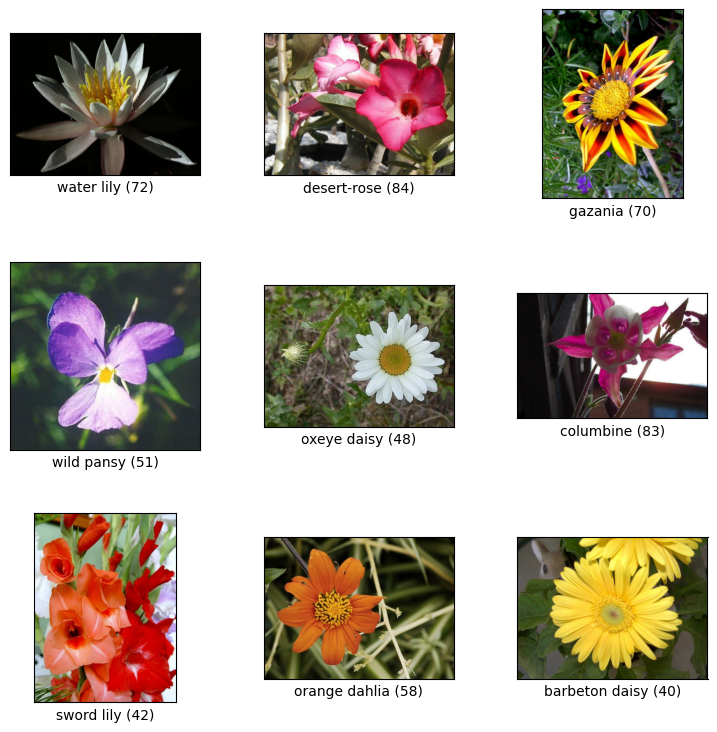

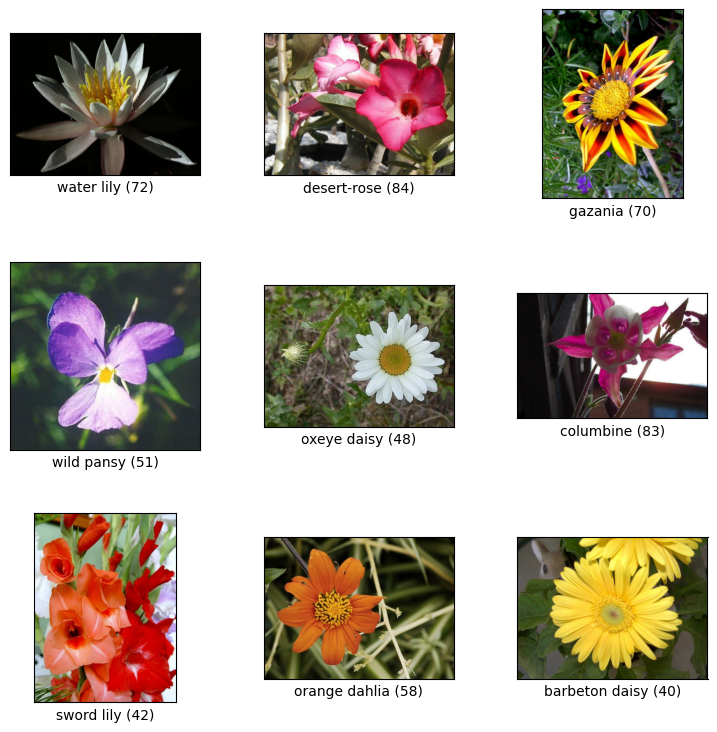

In [ ]:
tfds.show_examples(data, info)

,file_name,image,label
0,image_00297.jpg,,72 (water lily)
1,image_04771.jpg,,84 (desert-rose)
2,image_04537.jpg,,70 (gazania)
3,image_04238.jpg,,51 (wild pansy)
4,image_06242.jpg,,48 (oxeye daisy)

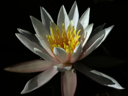
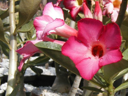
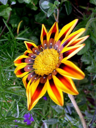
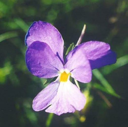
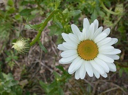

In [ ]:
tfds.as_dataframe(data.take(5), info)

**Create two lists containing image names and labels**

In [7]:
img_name_list = []
label_list = []
for dict_val in data:
  name = dict_val['file_name'].numpy().decode('utf-8')
  image = np.array(dict_val['image'])
  label = int(dict_val['label'])
  img_name_list.append(name)
  label_list.append(label)

In [ ]:
len(img_name_list)

8189

**Observe a random sample along with it's class**

73


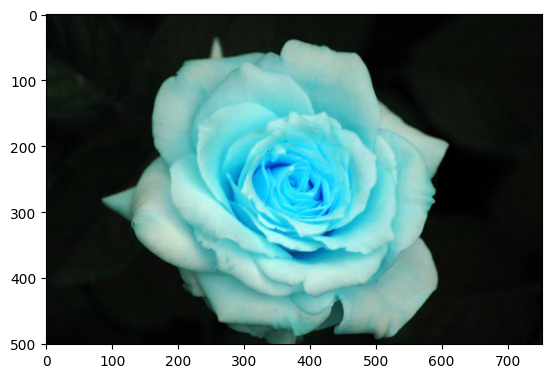

In [ ]:
rand_index = randrange(len(img_name_list))
img_path = os.path.join(img_dir, img_name_list[rand_index])

img = cv2.imread(img_path)
plt.imshow(img)
print(label_list[rand_index])

**Define a function to create image pairs:**

For each image I added:


1.   A positive pair with a random image of the same class
2.   A negative pair with a random image of another class

I could add all possible pairs, but then the dataset will be too large and I don't have enough resources to train it.



In [8]:
# Create pairs of image_names with labels
def create_pairs(image_names, classes):
  pairs = []
  labels = []
  class_indices = {}

  # Group image_names by class
  for i in range(len(image_names)):
    if classes[i] not in class_indices:
      class_indices[classes[i]] = []
    class_indices[classes[i]].append(image_names[i])

  labels_set = list(class_indices.keys())
  # For each image
  for i in range(len(image_names)):
    image1 = image_names[i]
    label1 = classes[i]

    # Add a positive pair
    image2 = random.choice(class_indices[label1])
    pairs.append((image1, image2))
    labels.append(1)
    # Add a negative pair
    label2 = random.sample(labels_set, 1)[0]
    while label2 == label1:
      label2 = random.sample(labels_set, 1)[0]
    image2 = random.choice(class_indices[label2])
    pairs.append((image1, image2))
    labels.append(0)

  # # Create positive pairs
  # for label, image_names in class_indices.items():
  #   for i in range(len(image_names)):
  #     for j in range(i+1, len(image_names)):
  #       pairs.append((image_names[i], image_names[j]))
  #       labels.append(1)

  # # Create negative pairs
  # labels_set = list(class_indices.keys())
  # for _ in range(len(pairs)):
  #   label1, label2 = random.sample(labels_set, 2)
  #   image1 = random.choice(class_indices[label1])
  #   image2 = random.choice(class_indices[label2])
  #   pairs.append((image1, image2))
  #   labels.append(0)

  return np.array(pairs), np.array(labels)

In [9]:
pairs, labels = create_pairs(img_name_list, label_list)

In [ ]:
len(labels)

16378

**Observe a random negative pair in dataset**

similar images

0


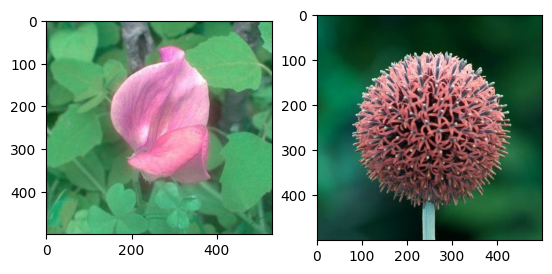

In [ ]:
rand_index = randrange(len(pairs))

img_path1 = os.path.join(img_dir, pairs[rand_index][0])
img_path2 = os.path.join(img_dir, pairs[rand_index][1])

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
print(labels[rand_index])
plt.show()

**Observe a random positive pair in dataset**

not similar

1


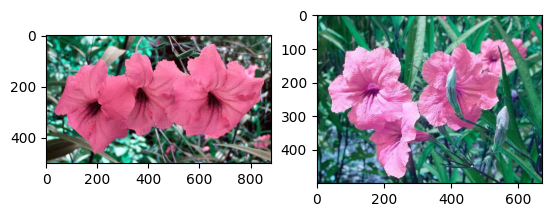

In [ ]:
rand_index = randrange(len(pairs))

img_path1 = os.path.join(img_dir, pairs[rand_index][0])
img_path2 = os.path.join(img_dir, pairs[rand_index][1])

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
print(labels[rand_index])
plt.show()

**Split the data into train and test subsets**

In [10]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42)

In [ ]:
len(y_train)

13102

In [ ]:
len(y_test)

3276

**Define a preprocess method:**

It change the size to (224, 224, 3) which is the model input size. It also calls vgg16 preprocess method.

In [11]:
def preprocess_image(image):
    img = cv2.resize(image, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

**Define a custom data generator:**

Batch size is 32 by default. For each batch, it reads the images by using their name and apply preprocessing.

In [12]:
# Define a generator class
class CustomDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, pairs, labels, batch_size=32, shuffle=True):
      self.pairs = pairs
      self.labels = labels
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.indexes = np.arange(len(self.pairs))
      self.on_epoch_end()

  # Number of batches
  def __len__(self):
      return int(np.floor(len(self.pairs) / self.batch_size))

  def __getitem__(self, index):
      batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
      batch_pairs = [self.pairs[k] for k in batch_indexes]
      batch_labels = [self.labels[k] for k in batch_indexes]

      X1, X2, y = self.__data_generation(batch_pairs, batch_labels)
      return [X1, X2], y

  def on_epoch_end(self):
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, batch_pairs, batch_labels):
    X1 =[]
    X2 = []
    for pair in batch_pairs:
      img_path1 = os.path.join(img_dir, pair[0])
      img_path2 = os.path.join(img_dir, pair[1])

      img1 = cv2.imread(img_path1)
      img2 = cv2.imread(img_path2)

      X1.append(preprocess_image(img1))
      X2.append(preprocess_image(img2))

    return np.array(X1), np.array(X2), np.array(batch_labels)

**Define train and test data generators**

In [13]:
# Create train and test data generators
train_generator = CustomDataGenerator(X_train, y_train)
test_generator = CustomDataGenerator(X_test, y_test)

**Define center loss layer:**

The implementation is based on the paper. The main idea is that each image be close to it's class's center.

In [14]:
""" Center loss based on the paper "A Discriminative
    Feature Learning Approach for Deep Face Recognition"
    (http://ydwen.github.io/papers/WenECCV16.pdf)
"""
class CenterLossLayer(Layer):
    def __init__(self, num_classes, feat_dim, alpha=0.5, **kwargs):
        super(CenterLossLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.alpha = alpha
        self.centers = self.add_weight(name='centers',
                                       shape=(num_classes, feat_dim),
                                       initializer='zeros',
                                       trainable=False)

    def call(self, y_true, y_pred):
        labels = tf.cast(y_true, tf.int32)
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = (1 - self.alpha) * (centers_batch - y_pred)

        # Update centers
        self.add_update(tf.compat.v1.scatter_sub(self.centers, labels, diff))

        # Compute the center loss
        loss = tf.reduce_mean(tf.square(y_pred - centers_batch))
        self.add_loss(loss)
        return y_pred

**Define total loss:**

I used center loss + binary cross entropy.

In [15]:
def combined_loss(y_true, y_pred):
    cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    center_loss = tf.reduce_sum(center_loss_layer.losses)  # Get the total center loss
    return cross_entropy_loss + center_loss

**Define the model:**

The base model is vgg16 which is a convolutional neural network that is 16 layers deep. This model is good for image classification.

Then we concat the result for two images and say if they are similar (1) or not (0).

In [16]:
input_shape = (224, 224, 3)
input_1 = Input(shape=input_shape)
input_2 = Input(shape=input_shape)

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False

x1 = base_model(input_1)
x2 = base_model(input_2)

x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)

x = Concatenate()([x1, x2])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Add center loss layer
center_loss_layer = CenterLossLayer(102, 1, 0.5)

model = Model(inputs=[input_1, input_2], outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[1][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1024)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        131,200 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,846,017 (56.63 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

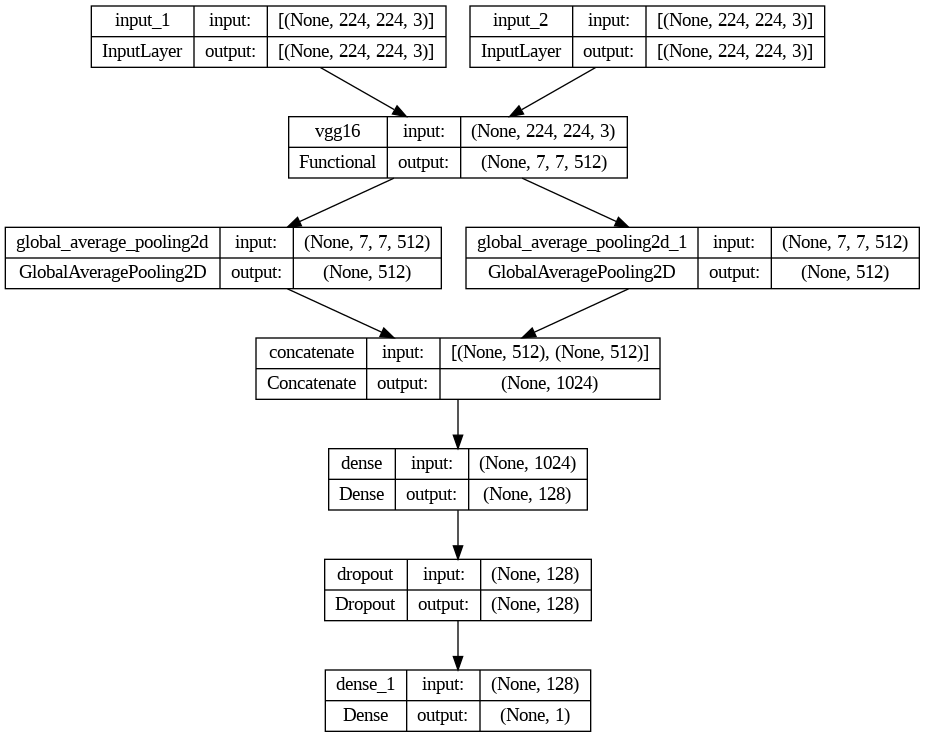

In [ ]:
tf.keras.utils.plot_model(model, "model_shape.png", show_shapes=True)

**Compile the model:**

combined loss function as loss, ROC_AUC as accuracy, and adam as optimizer.

In [18]:
model.compile(optimizer='adam', loss=combined_loss, metrics=[tf.keras.metrics.AUC()])

In [26]:
# Define the directory to save the checkpoints
checkpoint_dir = '/content/drive/MyDrive/Roshan/checkpoints'
checkpoint_path = checkpoint_dir + "/cp-{epoch:04d}.weights.h5"

# Create a callback that saves the model's weights
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch',  # Save after each epoch
    verbose=1
)

# add this to fit method
# callbacks=[checkpoint_callback]

# Load the weights from the checkpoint
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
# new_model.load_weights(latest_checkpoint)

**Train the model:**

I trained in 15 epochs.

In [ ]:
# Train the model7
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[checkpoint_callback]
)

Epoch 1/15
409/409 [==============================] - ETA: 0s - loss: 0.8253 - auc: 0.6328
Epoch 1: saving model to /content/drive/MyDrive/Roshan/checkpoints/cp-0001.h5
409/409 [==============================] - 420s 759ms/step - loss: 0.8253 - auc: 0.6328 - val_loss: 0.5733 - val_auc: 0.7882
Epoch 2/15
409/409 [==============================] - ETA: 0s - loss: 0.5765 - auc: 0.7559
Epoch 2: saving model to /content/drive/MyDrive/Roshan/checkpoints/cp-0002.h5
409/409 [==============================] - 282s 690ms/step - loss: 0.5765 - auc: 0.7559 - val_loss: 0.5144 - val_auc: 0.8323
Epoch 3/15
409/409 [==============================] - ETA: 0s - loss: 0.5222 - auc: 0.8098
Epoch 3: saving model to /content/drive/MyDrive/Roshan/checkpoints/cp-0003.h5
409/409 [==============================] - 287s 701ms/step - loss: 0.5222 - auc: 0.8098 - val_loss: 0.4816 - val_auc: 0.8581
Epoch 4/15
409/409 [==============================] - ETA: 0s - loss: 0.4884 - auc: 0.8380
Epoch 4: saving model to /c

**Load the wheights from checkpoint directory if needed**

In [20]:
# # Load the weights from the checkpoint
# # Specify the checkpoint path
# checkpoint_dir = '/content/drive/MyDrive/Roshan/checkpoints_back_3'
# epoch_number = 15
# checkpoint_path = checkpoint_dir + f'/cp-{epoch_number:04d}.h5'
# # Load weights from the specific checkpoint
# model.load_weights(checkpoint_path)

**Define a method to show final results**

In [ ]:
def show_final_result(history):
  # Plot separate loss curves for training and validation metrics.

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  auc = history.history['auc']
  val_auc = history.history['val_auc']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, auc, label='training_auc')
  plt.plot(epochs, val_auc, label='val_auc')
  plt.title('AUC')
  plt.xlabel('Epochs')
  plt.legend()

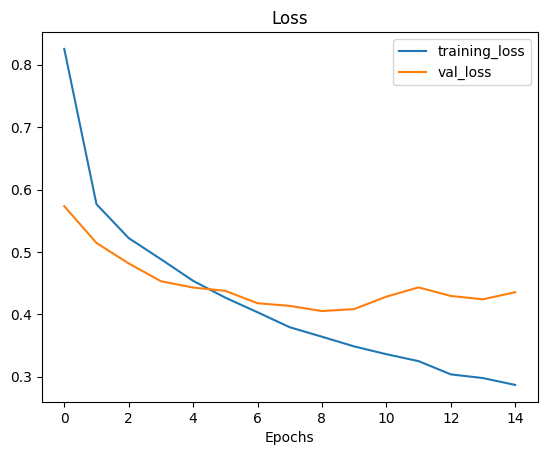

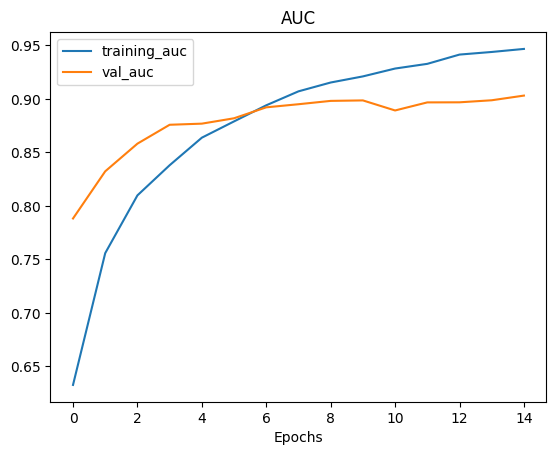

In [ ]:
show_final_result(history)

**Apply prediction on all test data**

In [ ]:
y_true = []
y_pred = []

for batch in test_generator:
    images, labels = batch
    predictions = model.predict(images)

    y_true.extend(labels)
    y_pred.extend(predictions)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 34ms/step


**Compute the accuracy which is 90%**

In [ ]:
roc_auc = roc_auc_score(y_true, y_pred)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9029390639554945


**Observe the result of model for a random pair of images**

1


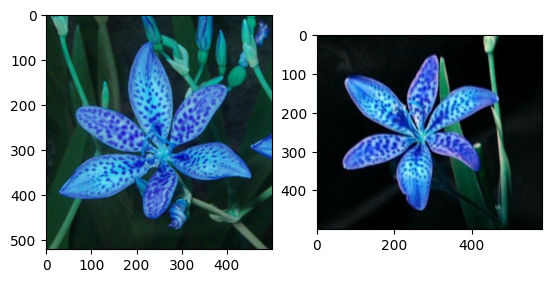

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.9994124]]


In [31]:
rand_index = randrange(len(X_test))
sample_pair = X_test[rand_index]

img_path1 = os.path.join(img_dir, sample_pair[0])
img1 = cv2.imread(img_path1)

img_path2 = os.path.join(img_dir, sample_pair[1])
img2 = cv2.imread(img_path2)

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
print(y_test[rand_index])
plt.show()

X1 = np.array([preprocess_image(img1)])
X2 = np.array([preprocess_image(img2)])
y = y_test[rand_index]

y_pred = model.predict([X1, X2])
print(y_pred)